# 代码融合

## MCMC抽样

### 导入库

In [28]:
import random
import tqdm
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from sklearn.neighbors import KernelDensity

### 历史收益率统计

<AxesSubplot:ylabel='Frequency'>

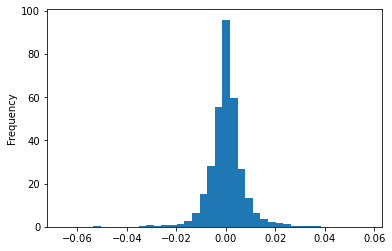

In [2]:
mon_lst = ['09', '10', '11', '12']
data1 = pd.read_excel('玉米连一.xlsx')
data1['month'] = data1['日期'].apply(lambda x: x.strftime("%m"))
data1['ret'] = data1['收盘价(元)'].pct_change()
data1 = data1[data1['month'].apply(lambda x: x in mon_lst)].drop(columns=['代码', '名称']).set_index('日期')['ret'].dropna()

mon_lst = ['01', '02', '03', '04']
data5 = pd.read_excel('玉米连五.xlsx')
data5['month'] = data5['日期'].apply(lambda x: x.strftime("%m"))
data5['ret'] = data5['收盘价(元)'].pct_change()
data5 = data5[data5['month'].apply(lambda x: x in mon_lst)].drop(columns=['代码', '名称']).set_index('日期')['ret'].dropna()

mon_lst = ['05', '06', '07', '08']
data9 = pd.read_excel('玉米连九.xlsx')
data9['month'] = data9['日期'].apply(lambda x: x.strftime("%m"))
data9['ret'] = data9['收盘价(元)'].pct_change()
data9 = data9[data9['month'].apply(lambda x: x in mon_lst)].drop(columns=['代码', '名称']).set_index('日期')['ret'].dropna()

data = pd.concat([data1, data5, data9])
data.plot(kind='hist', bins=40, density=True)

In [3]:
data.describe()

count    4295.000000
mean        0.000146
std         0.007286
min        -0.066026
25%        -0.002874
50%         0.000000
75%         0.003009
max         0.056938
Name: ret, dtype: float64

### KDE核函数

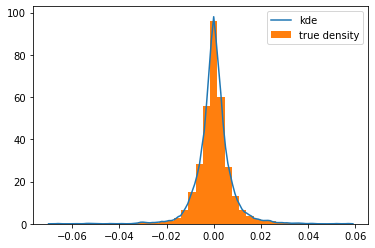

In [4]:
kde = KernelDensity(kernel='exponential', bandwidth=0.001).fit(data.values.reshape(-1, 1))

x = np.arange(-0.07, 0.06, 0.001)
y = np.exp(kde.score_samples(x.reshape(-1, 1)))
plt.plot(x, y, label='kde')
plt.hist(data, 40, density=True, label='true density')
plt.legend()

### M-H采样法

In [5]:
def dist_prob(theta):
    if type(theta) is float:
        theta = np.array([theta])
    y = np.exp(kde.score_samples(theta.reshape(-1, 1)))
    return y

# 参数设置
N = 45
paths = 50000

sample_size = (N - 1) * paths
pi = [0.1 for _ in range(sample_size)]
sigma = 1
t = 0


for t in tqdm.tqdm(range(sample_size - 1)):
    t = t + 1
    pi_star = norm.rvs(loc=pi[t - 1], scale=sigma, size=1, random_state=None)   #状态转移进行随机抽样
    alpha = min(1, (dist_prob(pi_star[0]) / dist_prob(pi[t - 1])))   #alpha值

    u = random.uniform(0, 1)
    if u < alpha:
        pi[t] = pi_star[0]
    else:
        pi[t] = pi[t - 1]

# 打乱
random.shuffle(pi)
# 调整形状
increments = np.array(pi).reshape((paths, N - 1))

100%|██████████| 2199999/2199999 [13:41<00:00, 2676.48it/s]


### 模拟路径绘图

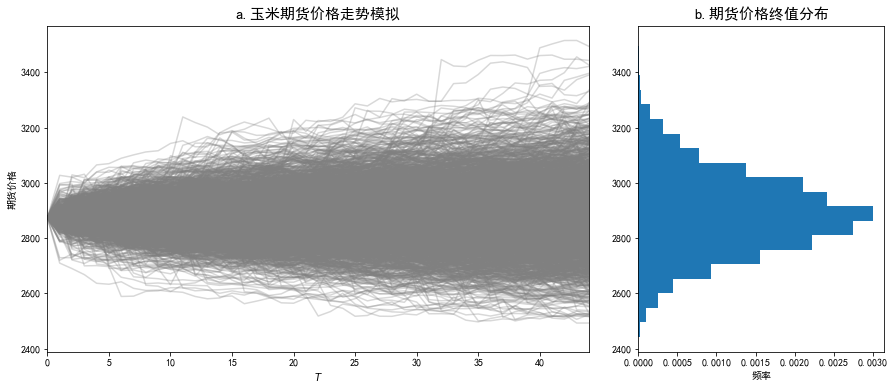

In [52]:
S0 = 2874
X0 = np.zeros((paths, 1))
# increments = ss.norm.rvs(loc=(r - sig**2/2)*dt, scale=np.sqrt(dt)*sig, size=(paths,N-1))
X = np.concatenate((X0, increments), axis=1).cumsum(1)
S = S0 * np.exp(X)
# 显示中文
plt.rcParams["font.sans-serif"]=["SimHei"]

fig = plt.figure(figsize=(15, 6))
gs = GridSpec(1, 3, figure=fig)
ax1 = fig.add_subplot(gs[:, :2])
ax2 = fig.add_subplot(gs[:, -1], sharey=ax1)
ax1.plot(S.T[:, :2000], color='grey', alpha=.3)
ax1.set_xlim(0, 44)
ax1.set_xlabel('$T$')
ax1.set_ylabel('期货价格')
ax1.set_title('a.玉米期货价格走势模拟', fontsize=15)
ax2.hist(S.T[-1, :5000], orientation='horizontal', bins=20, density=True)
ax2.set_xlabel('频率')
ax2.set_title('b.期货价格终值分布', fontsize=15)
plt.savefig('走势模拟.png', dpi=200, bbox_inches='tight')

## LS 模拟定价法

### 模拟定价函数

In [10]:
def LSM(S0, K, T, r, payoff, N=N, paths=paths):
    dt = T / (N-1)          # time interval
    df = np.exp(r * dt)  # discount factor per time time interval

    X0 = np.zeros((paths, 1))
    # increments = ss.norm.rvs(loc=(r - sig**2/2)*dt, scale=np.sqrt(dt)*sig, size=(paths,N-1))
    X = np.concatenate((X0, increments), axis=1).cumsum(1)
    S = S0 * np.exp(X)
    if payoff == "put":
        H = np.maximum(K - S, 0)   # intrinsic values for put option
    if payoff == "call":
        H = np.maximum(S - K, 0)   # intrinsic values for call option
    V = np.zeros_like(H)            # value matrix
    V[:,-1] = H[:,-1]

    # Valuation by LS Method
    for t in range(N-2, 0, -1):
        try:
            good_paths = H[:,t] > 0    
            # polynomial regression：将EV>0的部分挑出来回归
            rg = np.polyfit(S[good_paths, t], V[good_paths, t+1] * df, 2)    
            # 估计E(HV)
            C = np.polyval(rg, S[good_paths,t] )                             
            # 如果E(HV)<EV，那么行权
            exercise = np.zeros( len(good_paths), dtype=bool)
            exercise[good_paths] = H[good_paths,t] > C
            V[exercise,t] = H[exercise,t]
            V[exercise,t+1:] = 0
            discount_path = (V[:,t] == 0)
            V[discount_path,t] = V[discount_path,t+1] * df
        except Exception as e:
            print(e)
    V0 = np.mean(V[:,1]) * df  # 
    return V0

### 简单美式期权

In [17]:
S0 = 2874

call = LSM(S0, S0, 0.2, 0.015, 'call')
put = LSM(S0, S0, 0.2, 0.015, 'put')

call, put

(63.765435896620005, 49.466039842744934)

### 美式期权的“牛市价差”

In [18]:
# 主力合约2022-03-01的结算价
S0 = 2874

# 买入低价的看涨期权
call_low = LSM(S0, 2874, 0.2, 0.015, 'call')

# 卖出高价的看涨期权
call_high = LSM(S0, 3000, 0.2, 0.015, 'call')

In [19]:
call_low, call_high, call_low - call_high

(63.765435896620005, 18.33047024767041, 45.4349656489496)

### 美式期权“熊市价差”

In [20]:
S0 = 2874

# 买入高价的看跌期权
put_high = LSM(S0, 2874, 0.2, 0.015, 'put')
# 卖出低价的看跌期权
put_low = LSM(S0, 2700, 0.2, 0.015, 'put')

put_high, put_low, put_high - put_low

(49.466039842744934, 5.6567102089178, 43.80932963382713)

### 亚式期权定价

In [23]:
def asian_price(S0, K, T, r, payoff):
    X0 = np.zeros((paths, 1))
    X = np.concatenate((X0, increments), axis=1).cumsum(1)
    S = np.mean(S0 * np.exp(X), axis=1)
    if payoff == "put":
        H = np.maximum(K - S, 0)   # intrinsic values for put option
    if payoff == "call":
        H = np.maximum(S - K, 0)   # intrinsic values for call option
    H = H * np.exp(- r * T)
    return np.mean(H)

asian_call = asian_price(2874, 2874, 0.2, 0.015, 'call')
asian_put = asian_price(2874, 2874, 0.2, 0.015, 'put')
asian_call, asian_put

(36.09573085129966, 28.282920976191633)